In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import model
import simulate
from sklearn.metrics import r2_score
import importlib


In [2]:
device = "cpu"
random_seed = 2025
r2 = 0.5
n = 1000
dim = 112
coord, true_beta, img_data, y = simulate.simulate_data(n, r2, dim, random_seed)

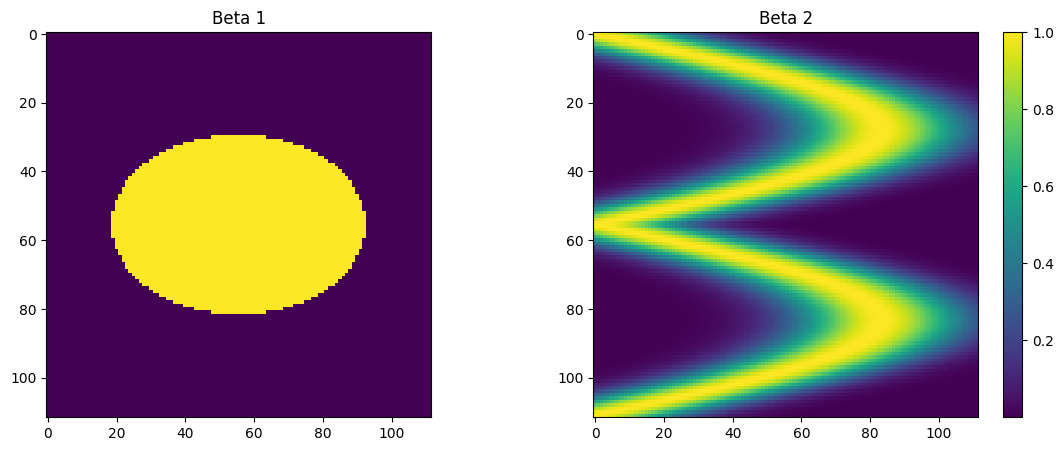

In [3]:
fig, axs = plt.subplots(1, 2, figsize = (14,5))
axs[0].imshow(true_beta[0].reshape(dim, dim))
axs[0].set_title("Beta 1")

cax = axs[1].imshow(true_beta[1].reshape(dim, dim))
axs[1].set_title("Beta 2")

fig.colorbar(cax, ax = axs[1])
plt.show()



In [4]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

image_data_0_reshaped = img_data[0].reshape(n, dim, dim)
image_data_1_reshaped = img_data[1].reshape(n, dim, dim)

stacked_img = np.concatenate([image_data_0_reshaped, image_data_1_reshaped], axis = 1)
stacked_img = stacked_img[:, np.newaxis, :, :]

y = y.reshape(-1, 1)
y_tensor = torch.tensor(y, dtype = torch.float32).to(device)
stacked_img_tensor = torch.tensor(stacked_img, dtype = torch.float32).to(device)

torch.manual_seed(random_seed)
np.random.seed(random_seed)

X_train, X_test, y_train, y_test = train_test_split(stacked_img_tensor, y_tensor, test_size = 0.2, random_state = random_seed)
train_dataset = TensorDataset(X_train, y_train)
test_dataset =  TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 16, shuffle = False)

In [ ]:

def train_cnn_model(model_class=model.CNN2d512, 
                    lr=0.001, 
                    weight_decay=0.0, 
                    num_epochs=100, 
                    train_loader=None, 
                    test_loader=None, 
                    device='cuda' if torch.cuda.is_available() else 'cpu',
                    verbose=True,
                    plot_results=True):
    """
    Train a CNN model with customizable parameters and track performance metrics.
    
    Args:
        model_class: CNN model class (default: CNN2d512)
        lr: Learning rate (default: 0.0001)
        weight_decay: L2 regularization (default: 0.01)
        num_epochs: Number of training epochs (default: 100)
        train_loader: Training data loader
        test_loader: Test/validation data loader
        device: Device to run training on
        verbose: Whether to print training progress
        plot_results: Whether to plot learning curves
    
    Returns:
        Dictionary containing training history and best metrics
    """
    # Initialize model, criterion and optimizer
    cnn = model_class().to(device)
    criterion = torch.nn.MSELoss()
    optimizer = optim.Adam(cnn.parameters(), lr=lr, weight_decay=weight_decay)

    # Initialize lists to track metrics
    train_losses = []
    test_losses = []
    all_train_r2 = []
    all_test_r2 = []
    
    best_epoch = 0
    best_test_loss = float('inf')
    best_test_r2 = -float('inf')

    for epoch in range(num_epochs):
        # --- Training Phase ---
        cnn.train()
        running_loss = 0.0
        y_pred, y_true = [], []
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            y_hat_batch = cnn(X_batch)
            loss = criterion(y_hat_batch, y_batch)
            loss.backward()
            optimizer.step()
            
            with torch.no_grad():
                running_loss += loss.item()
                y_pred.extend(y_hat_batch.detach().cpu().numpy().flatten())
                y_true.extend(y_batch.cpu().numpy().flatten())
        
        # Calculate training metrics
        epoch_train_loss = running_loss / len(train_loader)
        train_losses.append(epoch_train_loss)
        train_r2 = r2_score(y_true, y_pred)
        all_train_r2.append(train_r2)
        
        # --- Validation/Test Phase ---
        cnn.eval()
        with torch.no_grad():
            test_pred, test_true = [], []
            test_running_loss = 0.0
            
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_hat_batch = cnn(X_batch)
                loss = criterion(y_hat_batch, y_batch)
                test_running_loss += loss.item()
                test_pred.extend(y_hat_batch.detach().cpu().numpy().flatten())
                test_true.extend(y_batch.cpu().numpy().flatten())
            
            epoch_test_loss = test_running_loss / len(test_loader)
            test_losses.append(epoch_test_loss)
            test_r2 = r2_score(test_true, test_pred)
            all_test_r2.append(test_r2)
            
            # Update best epoch
            if epoch_test_loss < best_test_loss:
                best_test_loss = epoch_test_loss
                best_test_r2 = test_r2
                best_epoch = epoch + 1
        
        # Print metrics if verbose
        # if verbose and (epoch + 1) % 1 == 0:
        #     print(f"Epoch {epoch + 1}/{num_epochs}")
        #     print(f"  Train Loss: {epoch_train_loss:.4f} ± {np.std(train_losses):.4f}")
        #     print(f"  Train R²: {train_r2:.4f} ± {np.std(all_train_r2):.4f}")
        #     print(f"  Test Loss: {epoch_test_loss:.4f} ± {np.std(test_losses):.4f}")
        #     print(f"  Test R²: {test_r2:.4f} ± {np.std(all_test_r2):.4f}\n")

    # Final summary
    if verbose:
        print(f"\n=== {model_class.__name__} Training Summary ===")
        print(f"Best Epoch: {best_epoch}")
        print(f"Best Test Loss: {best_test_loss:.4f}")
        print(f"Corresponding Test R²: {best_test_r2:.4f}")
        print(f"Final Train Loss: {train_losses[-1]:.4f} ± {np.std(train_losses):.4f}")
        print(f"Final Train R²: {all_train_r2[-1]:.4f} ± {np.std(all_train_r2):.4f}")
        print(f"Final Test Loss: {test_losses[-1]:.4f} ± {np.std(test_losses):.4f}")
        print(f"Final Test R²: {all_test_r2[-1]:.4f} ± {np.std(all_test_r2):.4f}")

    # Plot results if requested
    if plot_results:
        plt.figure(figsize=(12, 5))

        # Plot Losses
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(test_losses, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('MSE Loss')
        plt.title(f'{model_class.__name__} Training & Test Loss')
        plt.legend()

        # Plot R² Scores
        plt.subplot(1, 2, 2)
        plt.plot(all_train_r2, label='Train R²')
        plt.plot(all_test_r2, label='Test R²')
        plt.xlabel('Epoch')
        plt.ylabel('R² Score')
        plt.title(f'{model_class.__name__} R² Scores')
        plt.legend()

        plt.tight_layout()
        plt.show()

    return {
        'model': cnn,
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_r2_scores': all_train_r2,
        'test_r2_scores': all_test_r2,
        'best_epoch': best_epoch,
        'best_test_loss': best_test_loss,
        'best_test_r2': best_test_r2,
        'final_train_loss': train_losses[-1],
        'final_test_loss': test_losses[-1],
        'final_train_r2': all_train_r2[-1],
        'final_test_r2': all_test_r2[-1]
    }

# Example usage:
# results = train_cnn_model(model_class=model.CNN2d512,
#                         lr=0.0001,
#                         weight_decay=0.01,
#                         num_epochs=100,
#                         train_loader=train_loader,
#                         test_loader=test_loader)

In [ ]:
import model
importlib.reload(model)      # Force-reload the module
from model import CNN2d512, CNN2d128, CNN2d64, CNN2d1fc, CNN2dgap      # Import the updated class


=== CNN2d512 Training Summary ===
Best Epoch: 2
Best Test Loss: 92.3620
Corresponding Test R²: 0.4140
Final Train Loss: 17.1564 ± 17.3315
Final Train R²: 0.8894 ± 0.1117
Final Test Loss: 117.4850 ± 102.0759
Final Test R²: 0.2557 ± 0.6561


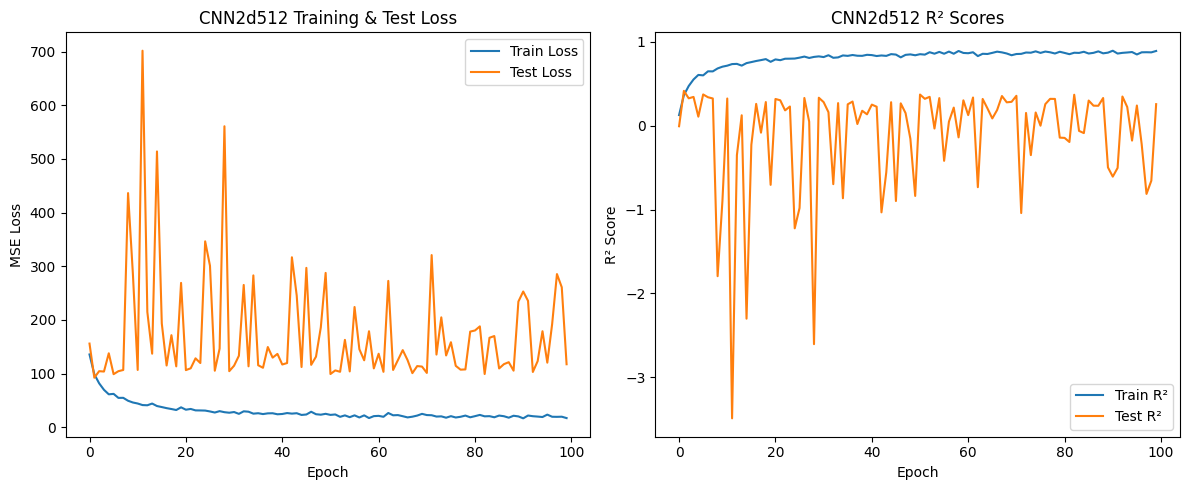

In [53]:
results = train_cnn_model(model_class=model.CNN2d512,
                        lr=0.001,
                        weight_decay=0.0,
                        num_epochs=100,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN2d128 Training Summary ===
Best Epoch: 21
Best Test Loss: 96.5954
Corresponding Test R²: 0.3774
Final Train Loss: 26.3984 ± 21.7626
Final Train R²: 0.8299 ± 0.1402
Final Test Loss: 117.7433 ± 108.6227
Final Test R²: 0.2343 ± 0.7034


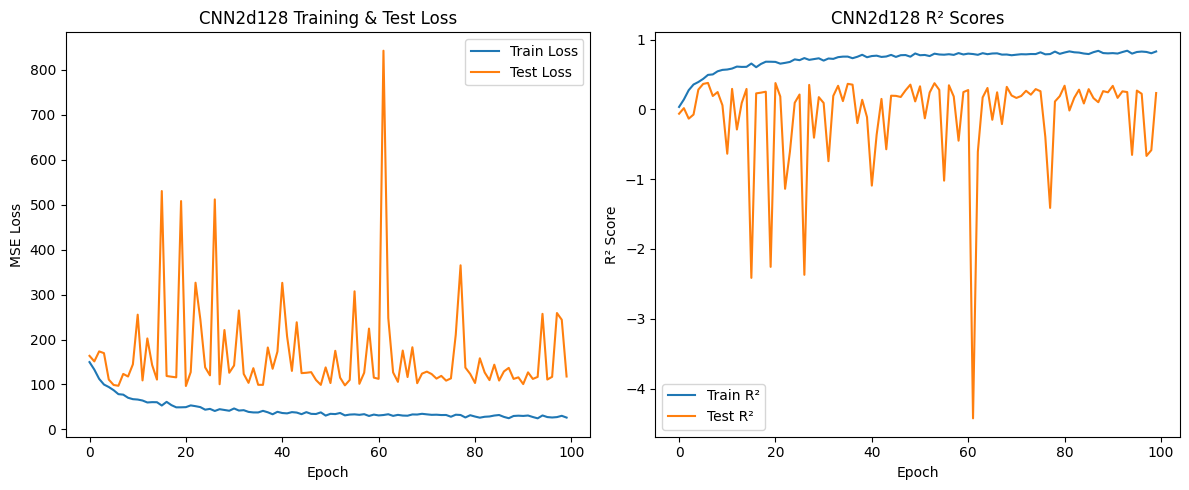

In [54]:
results = train_cnn_model(model_class=model.CNN2d128,
                        lr=0.001,
                        weight_decay=0.0,
                        num_epochs=100,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN2d64 Training Summary ===
Best Epoch: 17
Best Test Loss: 107.6364
Corresponding Test R²: 0.3116
Final Train Loss: 33.4193 ± 23.8500
Final Train R²: 0.7846 ± 0.1537
Final Test Loss: 120.2848 ± 49.0113
Final Test R²: 0.2247 ± 0.3116


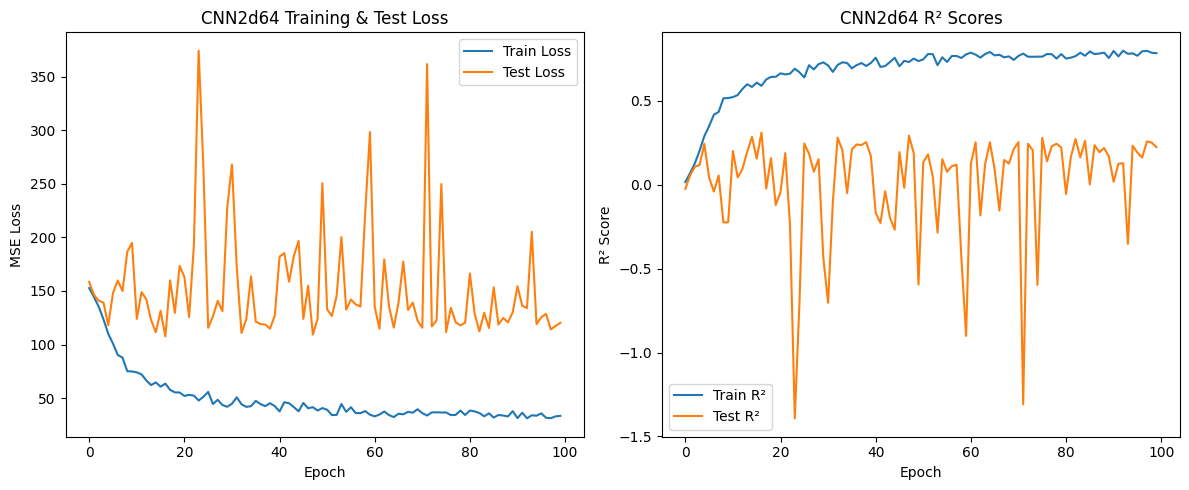

In [55]:
results = train_cnn_model(model_class=model.CNN2d64,
                        lr=0.001,
                        weight_decay=0.0,
                        num_epochs=100,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN2d1fc Training Summary ===
Best Epoch: 73
Best Test Loss: 113.4072
Corresponding Test R²: 0.2654
Final Train Loss: 13.7984 ± 36.0636
Final Train R²: 0.9111 ± 0.2324
Final Test Loss: 131.6569 ± 22.5322
Final Test R²: 0.1372 ± 0.1446


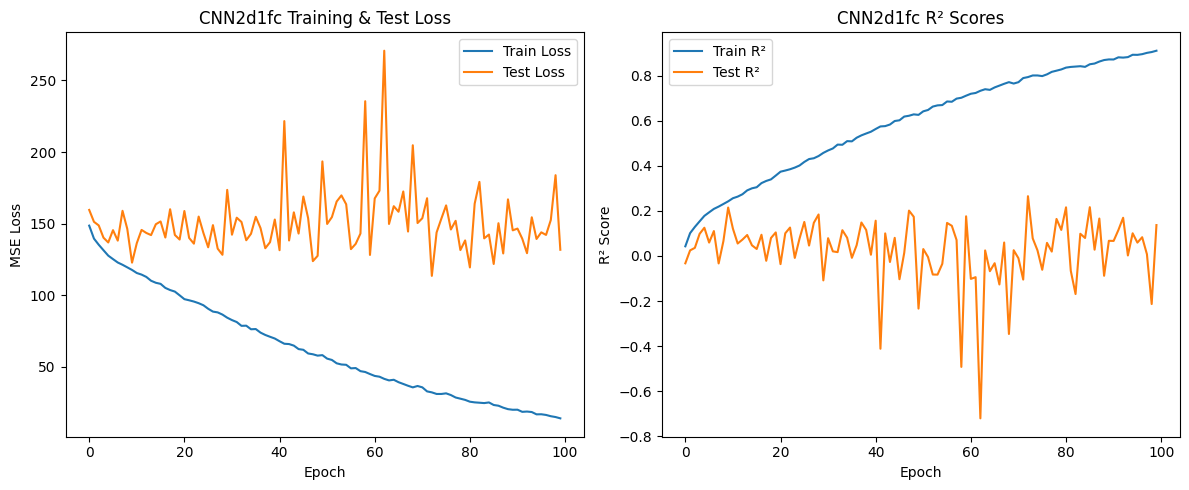

In [56]:
results = train_cnn_model(model_class=model.CNN2d1fc,
                        lr=0.001,
                        weight_decay=0.0,
                        num_epochs=100,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN2dgap Training Summary ===
Best Epoch: 39
Best Test Loss: 92.8756
Corresponding Test R²: 0.4077
Final Train Loss: 81.5900 ± 12.1672
Final Train R²: 0.4742 ± 0.0784
Final Test Loss: 163.1486 ± 279.0771
Final Test R²: -0.0678 ± 1.8014


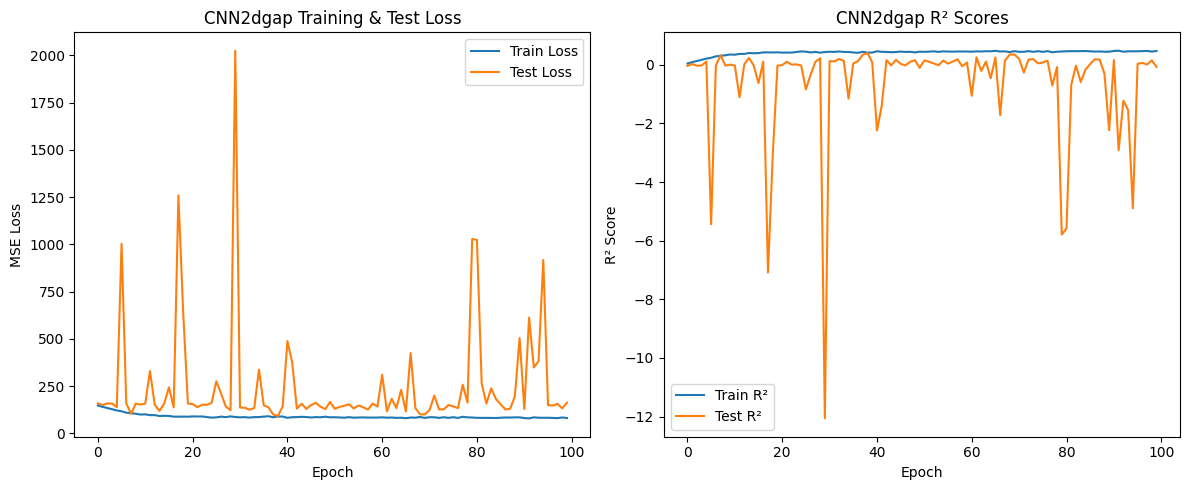

In [57]:
results = train_cnn_model(model_class=model.CNN2dgap,
                        lr=0.001,
                        weight_decay=0.0,
                        num_epochs=100,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN2d512 Training Summary ===
Best Epoch: 26
Best Test Loss: 85.7368
Corresponding Test R²: 0.4489
Final Train Loss: 21.4689 ± 29.5728
Final Train R²: 0.8617 ± 0.1906
Final Test Loss: 93.9954 ± 12.1828
Final Test R²: 0.3931 ± 0.0794


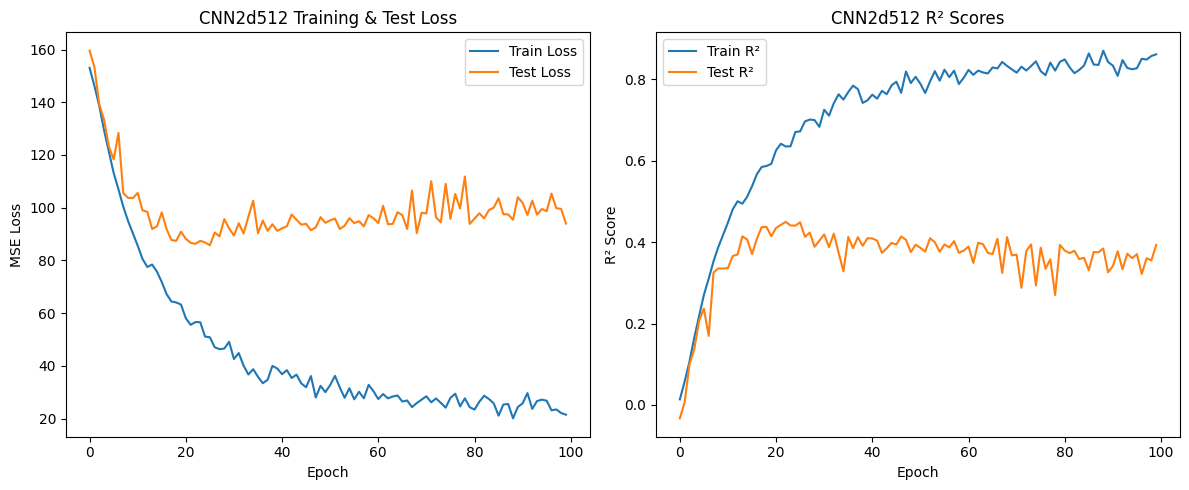

In [52]:
results = train_cnn_model(model_class=model.CNN2d512,
                        lr=0.0001,
                        weight_decay=0.0,
                        num_epochs=100,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN2d128 Training Summary ===
Best Epoch: 42
Best Test Loss: 97.2288
Corresponding Test R²: 0.3853
Final Train Loss: 32.6463 ± 38.8802
Final Train R²: 0.7896 ± 0.2505
Final Test Loss: 103.0475 ± 15.8159
Final Test R²: 0.3447 ± 0.1075


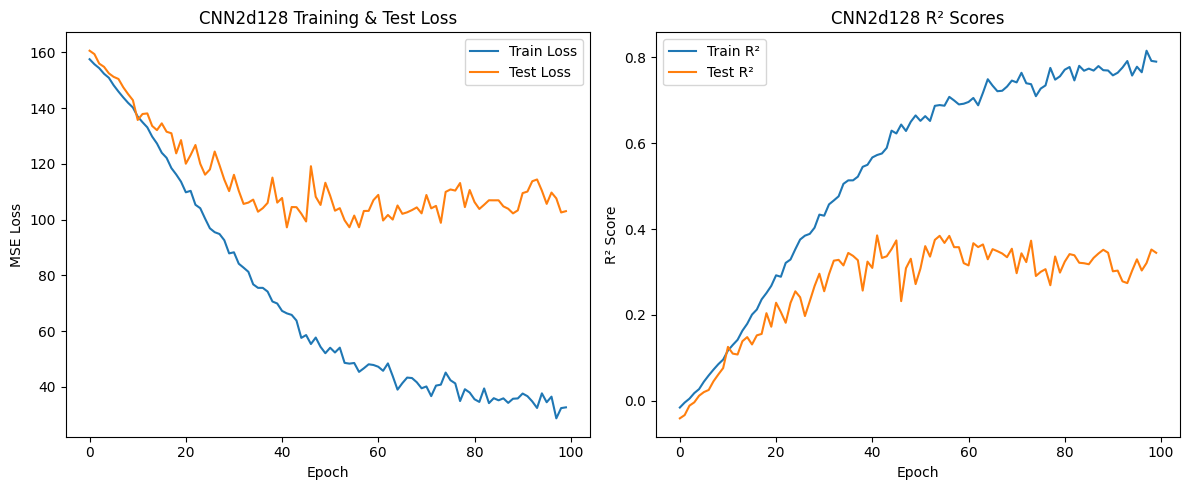

In [58]:
results = train_cnn_model(model_class=model.CNN2d128,
                        lr=0.0001,
                        weight_decay=0.0,
                        num_epochs=100,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN2d64 Training Summary ===
Best Epoch: 72
Best Test Loss: 107.5763
Corresponding Test R²: 0.3096
Final Train Loss: 40.2958 ± 36.3103
Final Train R²: 0.7403 ± 0.2340
Final Test Loss: 114.4535 ± 14.0776
Final Test R²: 0.2662 ± 0.0927


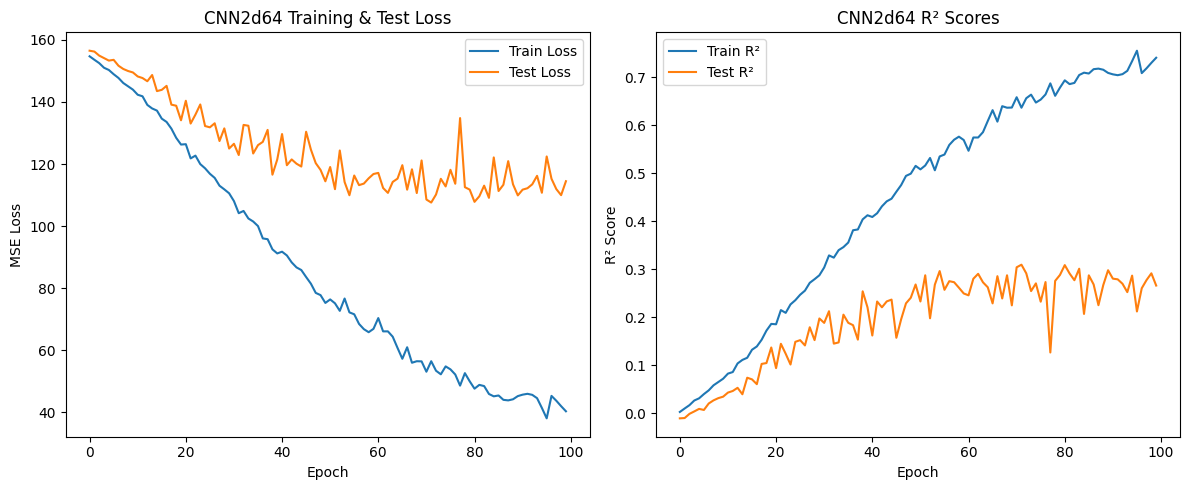

In [59]:
results = train_cnn_model(model_class=model.CNN2d64,
                        lr=0.0001,
                        weight_decay=0.0,
                        num_epochs=100,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN2d1fc Training Summary ===
Best Epoch: 100
Best Test Loss: 129.7516
Corresponding Test R²: 0.1608
Final Train Loss: 104.9952 ± 11.5992
Final Train R²: 0.3234 ± 0.0747
Final Test Loss: 129.7516 ± 5.1490
Final Test R²: 0.1608 ± 0.0331


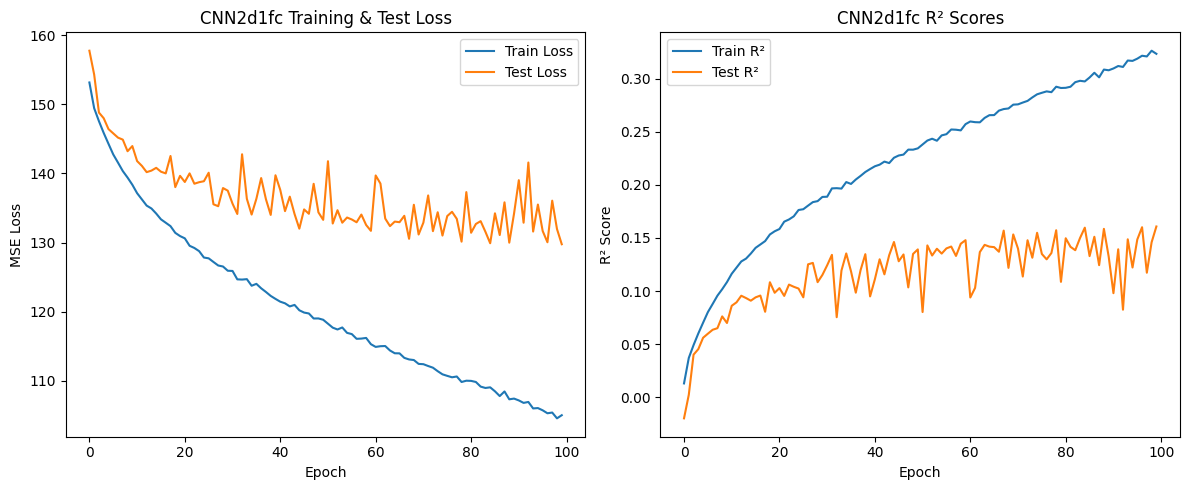

In [60]:
results = train_cnn_model(model_class=model.CNN2d1fc,
                        lr=0.0001,
                        weight_decay=0.0,
                        num_epochs=100,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN2dgap Training Summary ===
Best Epoch: 99
Best Test Loss: 97.1760
Corresponding Test R²: 0.3792
Final Train Loss: 99.4749 ± 15.8038
Final Train R²: 0.3590 ± 0.1018
Final Test Loss: 129.4087 ± 14.0538
Final Test R²: 0.1871 ± 0.0926


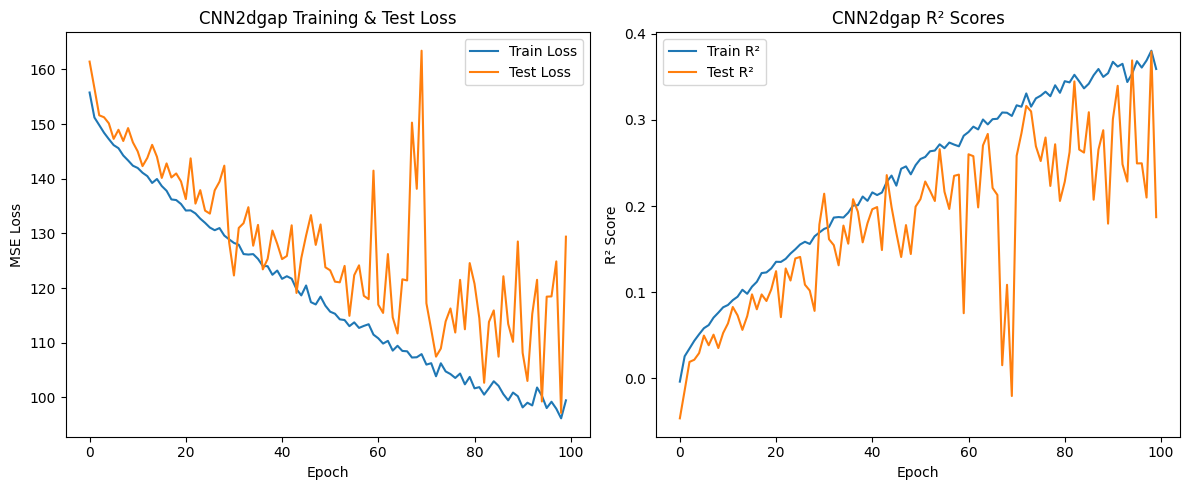

In [61]:
results = train_cnn_model(model_class=model.CNN2dgap,
                        lr=0.0001,
                        weight_decay=0.0,
                        num_epochs=100,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN2d512 Training Summary ===
Best Epoch: 23
Best Test Loss: 92.8822
Corresponding Test R²: 0.4012
Final Train Loss: 20.9283 ± 32.0484
Final Train R²: 0.8651 ± 0.2065
Final Test Loss: 105.0814 ± 11.2519
Final Test R²: 0.3063 ± 0.0727


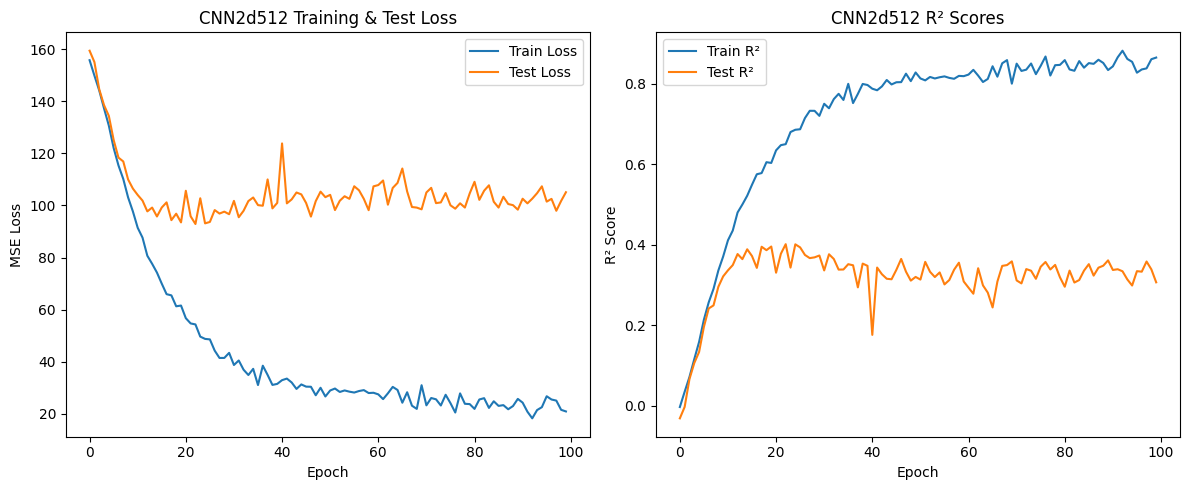

In [62]:
results = train_cnn_model(model_class=model.CNN2d512,
                        lr=0.0001,
                        weight_decay=0.01,
                        num_epochs=100,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN2d128 Training Summary ===
Best Epoch: 73
Best Test Loss: 100.0045
Corresponding Test R²: 0.3610
Final Train Loss: 30.8289 ± 40.1502
Final Train R²: 0.8013 ± 0.2587
Final Test Loss: 112.0815 ± 15.3710
Final Test R²: 0.2741 ± 0.0997


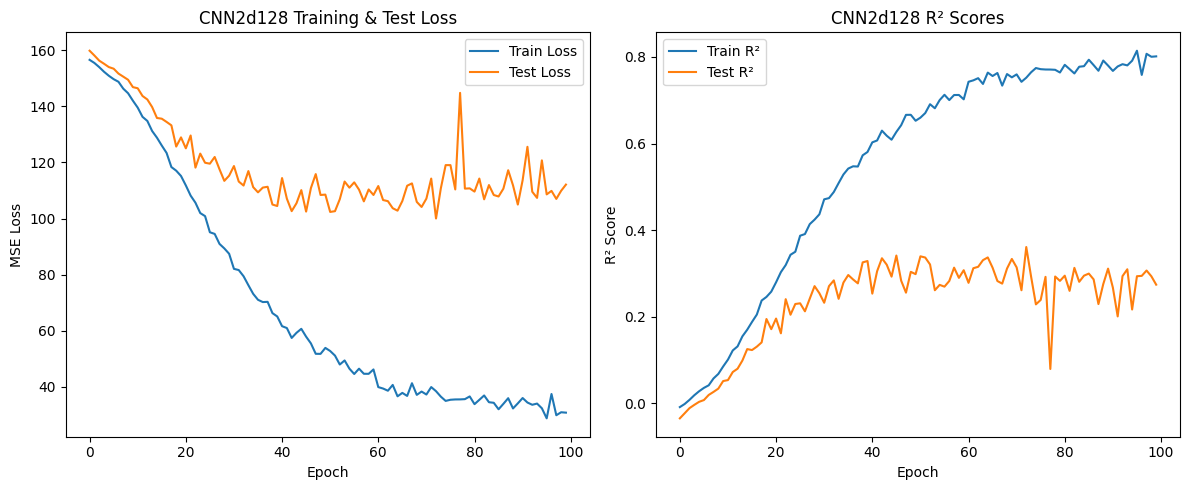

In [63]:
results = train_cnn_model(model_class=model.CNN2d128,
                        lr=0.0001,
                        weight_decay=0.01,
                        num_epochs=100,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN2d64 Training Summary ===
Best Epoch: 90
Best Test Loss: 105.2842
Corresponding Test R²: 0.3227
Final Train Loss: 39.8299 ± 37.9549
Final Train R²: 0.7433 ± 0.2446
Final Test Loss: 113.0719 ± 15.1405
Final Test R²: 0.2685 ± 0.0991


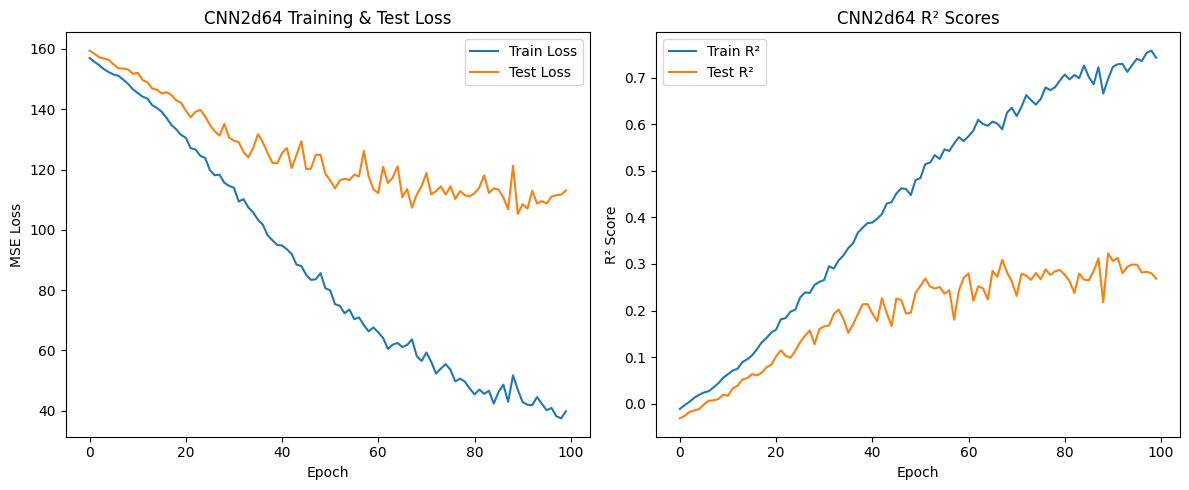

In [64]:
results = train_cnn_model(model_class=model.CNN2d64,
                        lr=0.0001,
                        weight_decay=0.01,
                        num_epochs=100,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN2d1fc Training Summary ===
Best Epoch: 100
Best Test Loss: 127.6556
Corresponding Test R²: 0.1750
Final Train Loss: 104.5442 ± 11.5551
Final Train R²: 0.3263 ± 0.0745
Final Test Loss: 127.6556 ± 5.4976
Final Test R²: 0.1750 ± 0.0351


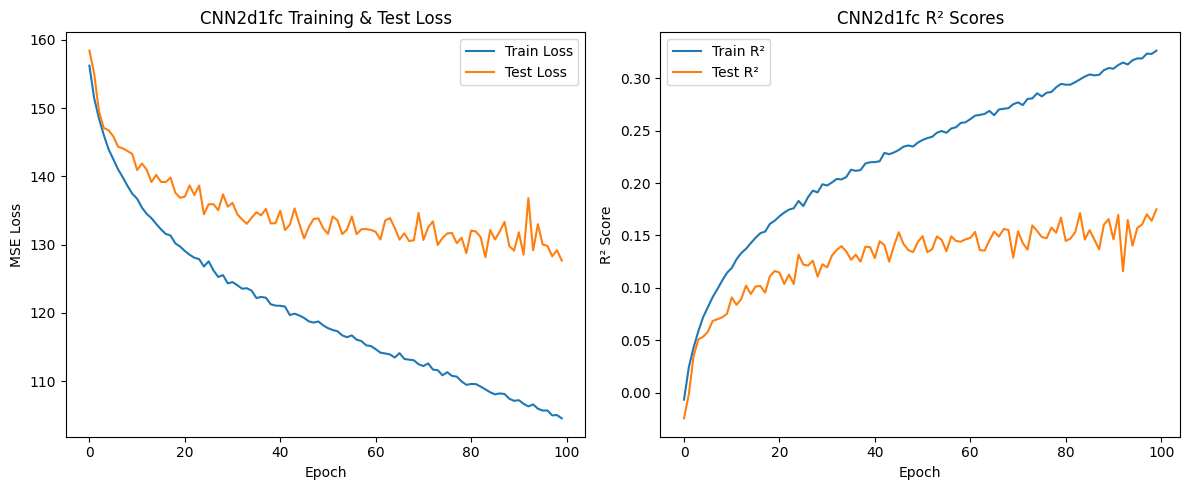

In [65]:
results = train_cnn_model(model_class=model.CNN2d1fc,
                        lr=0.0001,
                        weight_decay=0.01,
                        num_epochs=100,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN2dgap Training Summary ===
Best Epoch: 99
Best Test Loss: 96.7400
Corresponding Test R²: 0.3865
Final Train Loss: 100.6172 ± 15.2674
Final Train R²: 0.3516 ± 0.0984
Final Test Loss: 113.8142 ± 14.1319
Final Test R²: 0.2598 ± 0.0925


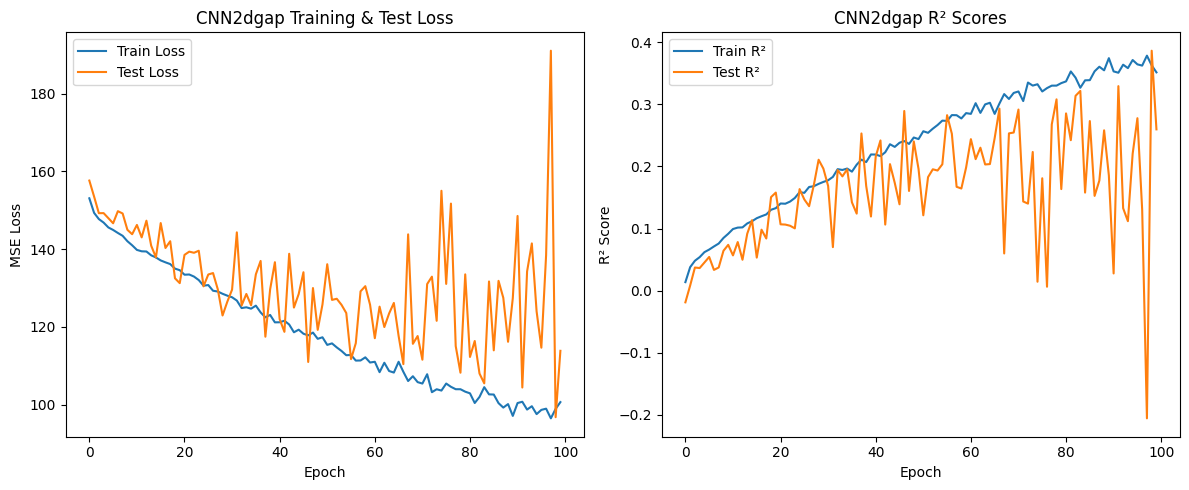

In [66]:
results = train_cnn_model(model_class=model.CNN2dgap,
                        lr=0.0001,
                        weight_decay=0.01,
                        num_epochs=100,
                        train_loader=train_loader,
                        test_loader=test_loader)

In [14]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

# image_data_0_reshaped = img_data[0].reshape(n, dim, dim)
# image_data_1_reshaped = img_data[1].reshape(n, dim, dim)

img_data_0_flat = img_data[0].reshape(n, -1)
img_data_1_flat = img_data[1].reshape(n, -1)


# stacked_img = np.concatenate([image_data_0_reshaped, image_data_1_reshaped], axis = 1)
# stacked_img = stacked_img[:, np.newaxis, :, :]
# y = y.reshape(-1, 1)
# y_tensor = torch.tensor(y, dtype = torch.float32).to(device)
# stacked_img_tensor = torch.tensor(stacked_img, dtype = torch.float32).to(device)

concatenated_img = np.concatenate([img_data_0_flat, img_data_1_flat], axis=1)
concatenated_img_tensor = torch.tensor(concatenated_img, dtype=torch.float32).to(device)
# create torch tensors
y = y.reshape(-1, 1)
y_tensor = torch.tensor(y, dtype = torch.float32).to(device)

# set random seed
torch.manual_seed(random_seed)
np.random.seed(random_seed)

X_train, X_test, y_train, y_test = train_test_split(concatenated_img_tensor, y_tensor, test_size = 0.2, random_state = random_seed)
train_dataset = TensorDataset(X_train, y_train)
test_dataset =  TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 16, shuffle = False)



In [15]:
# training
input_size = 2 * dim * dim
dnn = model.DNNModel(input_size=input_size).to(device)
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(dnn.parameters(), lr = 0.001)

num_epochs = 100
for epoch in range(num_epochs):
    dnn.train()
    running_loss = 0.0
    y_pred, y_true = [], []
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_hat_batch = dnn(X_batch)
        loss = criterion(y_hat_batch, y_batch)
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            running_loss += loss.item()
            y_pred.extend(y_hat_batch.detach().cpu().numpy().flatten())
            y_true.extend(y_batch.cpu().numpy().flatten())
    
    # print loss, training r2 and testing r2
    if (epoch + 1) % 5 == 0:
        train_r2 = np.corrcoef(y_true, y_pred)[0, 1] ** 2
        print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}, Train R^2: {train_r2}")

    if (epoch + 1) % 5 == 0:
        dnn.eval()
        with torch.no_grad():
            y_hat_test = dnn(X_test).detach().cpu().numpy().flatten()
            test_r2 = np.corrcoef(y_test.cpu().numpy().flatten(), y_hat_test)[0, 1] ** 2
        print(f"Epoch {epoch + 1}, Test R^2: {test_r2}")

Epoch 5, Loss: 76.1068960571289, Train R^2: 0.518350927538658
Epoch 5, Test R^2: 0.4044916048797007
Epoch 10, Loss: 62.34752883911133, Train R^2: 0.5987932596658913
Epoch 10, Test R^2: 0.40122575201536925
Epoch 15, Loss: 53.10646621704102, Train R^2: 0.6589839745597718
Epoch 15, Test R^2: 0.3241393137517917
Epoch 20, Loss: 52.30985549926758, Train R^2: 0.6634338259065691
Epoch 20, Test R^2: 0.35045066616694737
Epoch 25, Loss: 47.38542737960815, Train R^2: 0.6946944695488153
Epoch 25, Test R^2: 0.33904583615639533
Epoch 30, Loss: 37.447695083618164, Train R^2: 0.7587427087547988
Epoch 30, Test R^2: 0.35678085010265526
Epoch 35, Loss: 39.25070556640625, Train R^2: 0.7472180623881012
Epoch 35, Test R^2: 0.32424033538984187
Epoch 40, Loss: 37.598063716888426, Train R^2: 0.7577435276624359
Epoch 40, Test R^2: 0.35031256696445634
Epoch 45, Loss: 37.160780353546144, Train R^2: 0.7606066363519433
Epoch 45, Test R^2: 0.3636122348828199
Epoch 50, Loss: 35.90635190963745, Train R^2: 0.76865409616